## Data Exploration

**1. Find our experiment records**

In [1]:
from os import listdir
from os.path import isfile, join
data_raw = [f for f in listdir("data") if isfile(join("data", f))]
print(len(data_raw), "files:", str(data_raw))

**2. Save into a dictionary**

In [2]:
import csv
import numpy as np
data = {}
for experiment in data_raw:
    t, temp = [], []
    with open("data/"+experiment) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            t.append(int(row[0])/1e3)
            temp.append(float(row[1]))
        data[experiment[:-4]] = (np.array(t), np.array(temp))

**3. Plot**

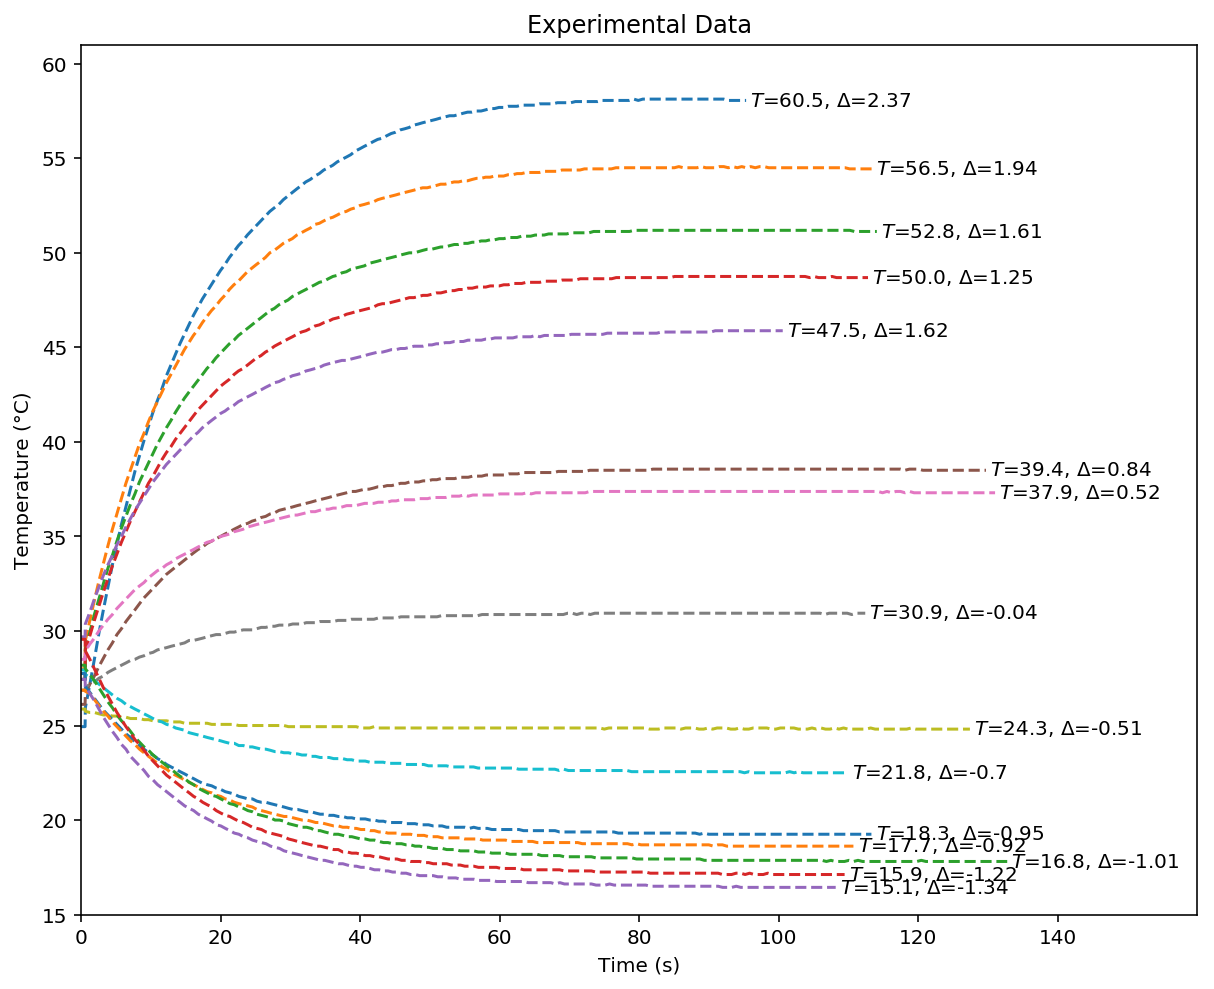

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(1, figsize=(10, 8))
plt.title("Experimental Data")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.xticks(np.arange(0, 160, step=20))
plt.xlim(0,160)
plt.ylim(15,61)
plt.yticks(np.arange(15, 61, step=5))

ordered_experiments = list(data.keys())
ordered_experiments.sort()
for experiment in ordered_experiments[::-1]:
    t, temp = data[experiment]
    plt.plot(t, temp, '--', label=r"$T_i$="+experiment)
    if float(experiment) < 28:
        label = round(float(experiment) - temp.min(), 2)
    else:
        label = round(float(experiment) - temp.max(), 2)
    plt.text(t[-1]+0.6,temp[-1]-0.3, r"$T$="+experiment+r", $\Delta$="+str(label))
    #plt.axhline(y=float(experiment), linestyle='--')
#plt.legend()
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

t, temp = data["56.5"]

"""plt.figure(2, figsize=(10, 8))
plt.plot(t, temp, '--', label=r"$T_i$="+experiment)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.show()"""

ln_t, ln_temp = [], []
for n, time in enumerate(t):
    ln_time = np.log(time)
    if (ln_time >= 0):
        ln_t.append(ln_time)
        ln_temp.append(np.log(temp[n]))
        
#print(t, temp)       
#print(ln_t, ln_temp)

"""plt.figure(3, figsize=(10, 8))
plt.plot(ln_t, ln_temp, '--')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.show()"""

ln_t = np.array(ln_t).reshape(-1, 1)
ln_temp = np.array(ln_temp).reshape(-1, 1)

regr = LinearRegression()
regr.fit(ln_t, ln_temp)
ln_temp_pred = regr.predict(ln_t)

print("Equation: ln(temp) =", regr.coef_[0], "ln(t) +", regr.predict([[0]])[0])
print("Mean squared error: %.3f" % mean_squared_error(ln_temp, ln_temp_pred))
print('Variance score: %.3f' % r2_score(ln_temp, ln_temp_pred)) # 1 is perfect prediction

prediction = regr.predict([[np.log(100)]])[0][0]
print("Predicted final temp:", np.exp(prediction))

"""plt.figure(4, figsize=(10, 8))
plt.scatter(ln_t, ln_temp, color='black')
plt.plot(ln_t, ln_temp_pred, color='blue', linewidth=3)
plt.show()"""

Equation: ln(temp) = [0.12794421] ln(t) + [3.4472337]
Mean squared error: 0.001
Variance score: 0.916
Predicted final temp: 56.62431988458892


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


"plt.figure(4, figsize=(10, 8))\nplt.scatter(ln_t, ln_temp, color='black')\nplt.plot(ln_t, ln_temp_pred, color='blue', linewidth=3)\nplt.show()"

In [5]:
failed = []
TIME_PRED = 70
for experiment in data.keys():
    t, temp = data[experiment]

    ln_t, ln_temp = [], []
    t_lim = 49
    for n, time in enumerate(t[:t_lim]):
        ln_time = np.log(time)
        if (ln_time >= 0):
            ln_t.append(ln_time)
            ln_temp.append(np.log(temp[n]))

    ln_t = np.array(ln_t).reshape(-1, 1)
    ln_temp = np.array(ln_temp).reshape(-1, 1)

    regr = LinearRegression()
    regr.fit(ln_t, ln_temp)
    ln_temp_pred = regr.predict(ln_t)

    prediction = regr.predict([[np.log(TIME_PRED)]])[0][0]
    prediction = round(np.exp(prediction), 2)
    error = round(abs(float(experiment) - prediction),2)
    PASS = (error<1.5)

    if PASS == False:
        failed.append(experiment)
    failed.sort()

    print("\n===========================================\n  Correct Temperature:", experiment)
    print("Predicted Temperature:", prediction, end=" ")
    print("(used data up to t =", t[t_lim-1], "s)")
    print("      Numerical error:", error)
    print("\nEquation: ln(temp) =", regr.coef_[0], "ln(t) +", regr.predict([[0]])[0])
    print("    PASS:", PASS)
    #print("Mean squared error: %.3f" % mean_squared_error(ln_temp, ln_temp_pred), end=", ")
    #print('Variance score: %.3f' % r2_score(ln_temp, ln_temp_pred), "\n") # 1 is perfect prediction
print("\nFailed:", failed, "using prediction time", TIME_PRED)


  Correct Temperature: 18.3
Predicted Temperature: 19.57 (used data up to t = 21.979 s)
      Numerical error: 1.27

Equation: ln(temp) = [-0.08884761] ln(t) + [3.35129582]
    PASS: True

  Correct Temperature: 16.8
Predicted Temperature: 18.59 (used data up to t = 21.979 s)
      Numerical error: 1.79

Equation: ln(temp) = [-0.11447083] ln(t) + [3.40918509]
    PASS: False

  Correct Temperature: 60.5
Predicted Temperature: 65.47 (used data up to t = 21.913 s)
      Numerical error: 4.97

Equation: ln(temp) = [0.23586518] ln(t) + [3.17952699]
    PASS: False

  Correct Temperature: 30.9
Predicted Temperature: 31.17 (used data up to t = 21.954 s)
      Numerical error: 0.27

Equation: ln(temp) = [0.03819749] ln(t) + [3.27713684]
    PASS: True

  Correct Temperature: 37.9
Predicted Temperature: 38.06 (used data up to t = 21.939 s)
      Numerical error: 0.16

Equation: ln(temp) = [0.07250071] ln(t) + [3.33114854]
    PASS: True

  Correct Temperature: 24.3
Predicted Temperature: 24.7